In [1]:
using MIRTjim
using Plots
using FFTW
using Random
using LinearAlgebra
using MAT

include("utils.jl");

In [2]:
# read in data from mat file
kdata = matread("./data/2D_T1_data.mat")["kData"];

# get sizes
nd = ndims(kdata) - 1; # number of image dimensions
N = size(kdata)[1:nd]; # image size
Q = size(kdata, nd + 1); # number of channels

In [ ]:
# set PISCO parameters
τ = Int(3); # neighborhood size (radius)
N_cal = 32; # size of calibration region
σ_thresh = 0.002; # threshold for singular values
d_sk = 50; # sketch dimension for SVD of ChC (overestimation of the rank)

# set PISCO techniques
kernel_shape = 1; # (0 for rect, 1 for circle)
fft_C_mtx = 1; # option to approximate ChC with FFTs
fft_G_mtx = 1; # option to approximate G with FFTs

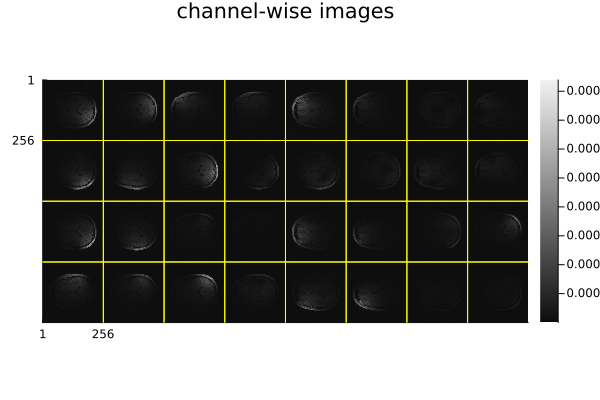

In [4]:
# get aliased image
idata = fftshift(ifft(ifftshift(kdata,1:nd),1:nd),1:nd);
jim(idata, title="channel-wise images")

In [5]:
# extract calibration data from kcal
cal_sidx = ntuple(d -> ceil.(Int,N[d]/2) + even_RL(N[d]/2) .+
    (-floor(Int,N_cal/2):floor(Int,N_cal/2)-even_RL(N_cal/2)), 
    nd); # subscript indices for calibration region (vector of vectors for each dim)
kcal = kdata[cal_sidx..., :];

# create kernel neighborhood
Λ_cidx = grid([-τ:τ for d in 1:nd]...); # coordinate indicies for kernel neighborhood
if kernel_shape == 1
    cmask = vec(sum(Λ_cidx.^2, dims=2)) .<= τ^2;
    Λ_cidx = Λ_cidx[cmask, :] # mask out edges if using ellipsoidal kernel
end
Λ_len = size(Λ_cidx,1); # final kernel (patch) size

In [ ]:
# form the convolution gram matrix ChC
if fft_C_mtx == 0 # naive approach

    # calculate convolution matrix C
    C = zeros(ComplexF64, (N_cal .- 2*τ .- even_RL.(N_cal))^nd, Λ_len, Q);
    k_cidx = grid(ntuple(d -> τ+1+even_RL(N_cal):N_cal-τ, nd)...); # grid of shift points
    for i in 1:size(k_cidx,1)
        idcs = ntuple(d -> k_cidx[i, d] .+ Λ_cidx[:, d], nd); # shifted indicies
        for q in 1:Q
            C[i,:,q] .= getindex.(Ref(kcal), idcs..., q);
        end
    end
    C = reshape(C, ((N_cal .- 2*τ .- even_RL.(N_cal))^nd, Λ_len*Q)); # reshape

    # calculate ChC via matrix product
    ChC = C'*C;

else # direct FFT-based approach

    # precompute ft of zero-padded s_q for q = 1,...Q
    N_pad = 2^(ceil(log2(N_cal + 2 * τ)));
    s = zeros(ComplexF64, Int.(N_pad * ones(nd))..., Q);
    cal_sidx_pad = ntuple(d -> ceil.(Int, N_pad / 2) + even_RL(N_pad / 2) .+
                    (-floor(Int, N_cal / 2):floor(Int, N_cal / 2)-even_RL(N_cal / 2)),
                    nd); # subscript indices for calibration region (padded)
    s[cal_sidx_pad..., :] .= kcal; # zero-padded s
    ρ = fftshift(fft(s, 1:nd), 1:nd); # ft of zero-padded s

    # columns of each C_p^H C_q block
    ChC_blocks = zeros(ComplexF64, Λ_len, Λ_len, Q, Q);
    pad_cidx = grid(ntuple(_ -> -floor(Int, N_pad / 2):floor(Int, N_pad / 2)-even_RL(N_pad / 2), nd) ...); # linear indices for padded calibration region
    φ = exp.(-1im * 2 * pi * (Λ_cidx / N_pad) * pad_cidx'); # phase kernel for applying shifts in fourier domain
    for p in 1:Q, q in 1:Q
        # compute ft(s_p[n] ⊗ conj(s_q[-n])) = ρ_p* * ρ_q
        ρρ_pq = conj(ρ[ntuple(_ -> Colon(), nd)..., p]) .* ρ[ntuple(_ -> Colon(), nd)..., q];

        for i in 1:Λ_len # loop through all shift indicies
            # calculate δ[n - n_i] ⊗ s_p[n] ⊗ conj(s_q[-n])
            φρρ_pqi = reshape(φ[i,:], size(ρρ_pq)) .* ρρ_pq; # φ_i * conj(ρ_p) * ρ_q
            δss_pqi = fftshift(ifft(ifftshift(φρρ_pqi, 1:nd), 1:nd), 1:nd); # δ[n - n_i] ⊗ s_p[n] ⊗ conj(s_q[-n]) = ift(φ_i * conj(ρ_p) * ρ_q)

            # extract patch and write to ChC block
            idcs = ntuple(d -> round(Int, N_pad / 2) + even_RL(N_pad / 2) .+ Λ_cidx[:, d], nd);
            ChC_blocks[:, i, p, q] .= getindex.(Ref(δss_pqi), idcs...);
        end
    end

    # reshape blocks
    ChC = reshape(permutedims(ChC_blocks, (1, 3, 2, 4)), (Λ_len * Q, Λ_len * Q));

end

928×928 Matrix{ComplexF64}:
   9.10766e-8+6.61744e-24im  …   2.21229e-10-2.95948e-10im
  -3.47819e-8+1.41909e-8im      -3.24873e-10-8.8273e-11im
   3.20397e-8+5.29194e-8im       5.41794e-10+1.69404e-10im
   6.37909e-8-4.01498e-8im       1.85327e-10-5.95625e-10im
  -3.92969e-8-4.9192e-8im       -2.55182e-10+1.2565e-10im
  -2.53666e-8+3.75261e-8im   …    3.1632e-10+1.90727e-10im
  -8.49237e-9+1.74939e-8im      -4.13832e-10+1.27737e-9im
   3.21554e-8+1.25238e-8im        1.45645e-9-1.23734e-10im
   1.40268e-8-4.17439e-8im      -3.23337e-10-1.02541e-9im
  -4.09801e-8-6.10325e-9im      -3.53898e-10+4.67943e-10im
             ⋮               ⋱  
 -3.23337e-10+1.02541e-9im      -1.09037e-10+3.42366e-10im
   1.45645e-9+1.23734e-10im  …   2.02746e-10+1.38692e-10im
 -4.13832e-10-1.27737e-9im      -2.65877e-11+1.87584e-11im
   3.1632e-10-1.90727e-10im     -6.69282e-11-4.93163e-10im
 -2.55182e-10-1.2565e-10im      -1.17277e-10+6.3209e-10im
  1.85327e-10+5.95625e-10im       1.35761e-9+5.5512e-10im
 

In [ ]:
# take the sketched SVD of ChC to find its null space
S = 1/sqrt(d_sk) * (randn(d_sk, Λ_len*Q) + 1im * randn(d_sk, Λ_len*Q)); 
(~,σ,V) = svd(S * ChC);
r = count(σ/σ[1] .> σ_thresh);
Vr = V[:, 1:r]; # get the column space basis of C
P = size(Vr,2); # get number of filters

928×928 Matrix{ComplexF64}:
     0.816137-0.0im          …   -0.00125582+0.00104674im
   0.00487429-0.0023228im         0.00135674+8.5834e-5im
   -0.0254338-0.0377875im       -0.000311392-0.00117818im
   -0.0623854+0.0363352im        0.000100344+0.00127398im
    0.0250313+0.0447249im       -0.000195437-0.000334451im
    0.0238885-0.0120002im    …    0.00019367+0.00011436im
   -0.0180755+0.00574036im      -0.000388977+0.000450167im
  -0.00358704+0.00402477im       -0.00127175+0.000491353im
  -0.00352652+0.0137569im         0.00198977+0.00129113im
   0.00953428+0.00322081im      -0.000992351-0.00140678im
             ⋮               ⋱  
   0.00070151-0.00108582im       0.000310906-5.26556e-5im
 -0.000948766-9.17675e-5im   …   -2.90937e-5-4.03805e-5im
   -8.7354e-5+0.00138576im       -5.11241e-5-0.000205291im
   0.00210884-0.000264806im      -0.00019468+0.000655311im
    0.0011023-0.000505931im       0.00065366-0.000320804im
  0.000742711-0.00114861im       -0.00109182-0.000771851im
 -0.0

In [ ]:
# reshape W into blocks
W = I - Vr*Vr'; # null space projection matrix
W_blocks = permutedims(reshape(W, Λ_len, Q, Λ_len, Q), (2,4,1,3)); # Q x Q x Λ_len x Λ_len

# form the fourier transform of G(x)
ft_G = zeros(ComplexF64, Q, Q, (2 * (2 * τ + 1))^nd);
Lidx = LinearIndices(ones([2 * (2 * τ + 1) for d in 1:nd]...));
for s = 1:Λ_len
    idcs = vcat(ntuple(i -> Lidx[[2*τ + 2 + Λ_cidx[Λ_len-i+1, d] + Λ_cidx[s, d] for d in 1:nd]...], Λ_len)...);
    ft_G[:, :, idcs] .+= W_blocks[:, :, :, s];
end
ft_G = reshape(ft_G, Q, Q, [2 * (2 * τ + 1) for d in 1:nd]...);

# zero-pad ft_G for interpolation
ft_G_zp = zeros(ComplexF64, Q, Q, N...);
ft_G_zp[:, :, ntuple(d -> floor(Int,N[d]/2) .+ (-(2*τ+1):2*τ), nd)...] .= ft_G;

# create phase kernel (why?)
full_cidx = grid(ntuple(d -> -floor(Int,N[d]/2):floor(Int,N[d]/2)-even_RL(N[d]), nd)...); # coordinate indices for calibration region
φ2 = exp.(-1im * 2 * pi * (full_cidx ./ [N...]') * ([N...] .- (2*τ + 1)));
φ2 = reshape(φ2, N...);

# compute ift of G
G = fft(conj.(ft_G_zp), 3:nd+2) .* reshape(φ2, 1, 1, N...); # ift of G in last nd dims
G = fftshift(G, 3:nd+2); # fftshift
G = reshape(G, Q, Q, prod(N));

# normalize G by the length of the kernel
G /= Λ_len;

# estimate sensitivity maps from G
smaps_est = zeros(ComplexF64, Q, prod(N));
ev_est = zeros(ComplexF64, Q, prod(N));
for x in 1:prod(N) # loop through vo/pixels
    # estimate sensitivity at x as last null space vector of G(x)
    (~,σ,V) = svd(G[:,:,x]);
    smaps_est[:,x] = V[:,end];
    ev_est[:,x] = σ;
end
smaps_est = permutedims(reshape(smaps_est, Q, N...), ((2:nd+1)..., 1));
ev_est = permutedims(reshape(ev_est, Q, N...), ((2:nd+1)..., 1));

In [52]:
# ft the filters to the image domain
f_p = zeros(ComplexF64, P, Q, N...);
for i in 1:Λ_len
    f_p[:, :, [Int(N[d]/2) + Λ_cidx[i,d] for d in 1:nd]...] .= reshape(conj.(Vr'), P, Λ_len, Q)[:,i,:];
end
h_p = fftshift(ifft(ifftshift(f_p, 3:nd+2), 3:nd+2), 3:nd+2);

# form H(x) matrix
H = reshape(h_p,P,Q,prod(N));

# estimate sensitivity maps
smaps_est = zeros(ComplexF64, Q, prod(N));
ev_est = zeros(ComplexF64, Q, prod(N));
for x in 1:prod(N) # loop through vo/pixels
    # estimate sensitivity at x as last null space vector of G(x)
    (~,σ,V) = svd(H[:,:,x]'*H[:,:,x]);
    smaps_est[:,x] = V[:,1];
    ev_est[:,x] = σ;
end
smaps_est = permutedims(reshape(smaps_est, Q, N...),((2:nd+1)...,1));
ev_est = permutedims(reshape(ev_est, Q, N...),((2:nd+1)...,1));

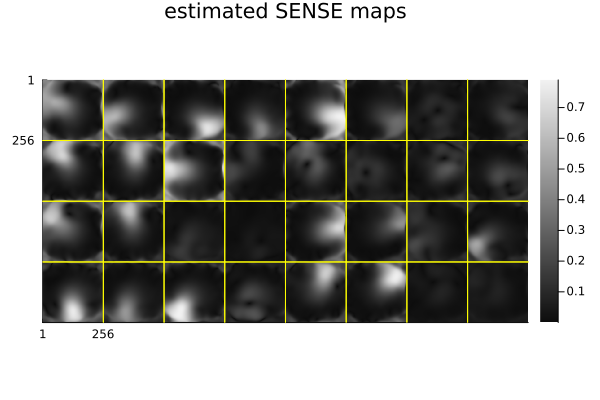

In [65]:
# show the sensitivity maps
jim(smaps_est, title="estimated SENSE maps")

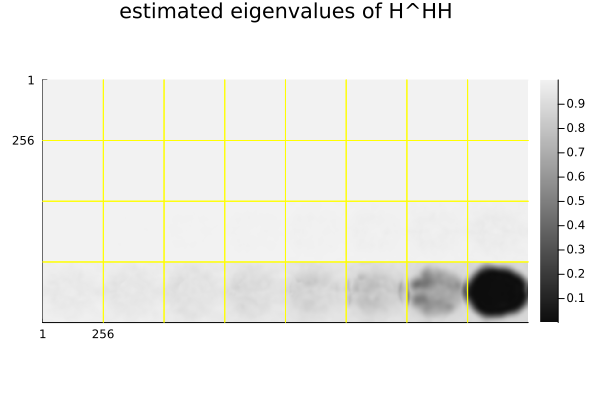

In [69]:
# show the eigenvalues of H'H
jim(ev_est, title="estimated eigenvalues of H^HH")

To do:
- calculate NPR based on changes:
    - estimate ChC with FFT and see change in NPR